In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

In [2]:
df=pd.read_csv('unusual_drop_preprocess_all_v4.csv')

In [3]:
df.head()

,acc_now_delinq,acc_open_past_24mths,addr_state,annual_inc,bc_open_to_buy,bc_util,chargeoff_within_12_mths,collections_12_mths_ex_med,delinq_2yrs,dti,...,total_rev_hi_lim,verification_status,emp_length,fico,credit_hist_months,have_bc,have_rev,treasury,funded_amnt,irr
0,0.0,8.0,OK,11.608245,8.702178,70.374384,0,0,1,34.70,...,10.317483,Verified,10+ years,672.0,278,1,1,0.000889,23200.0,-0.028885
1,0.0,5.0,TX,11.082158,10.919099,6.566836,0,0,0,17.74,...,11.157707,Not Verified,unknown,822.0,401,1,1,0.001392,16000.0,-0.016852
2,0.0,3.0,FL,10.819798,7.815207,73.376344,0,0,0,6.99,...,9.532569,Not Verified,5 years,702.0,226,1,1,0.001228,4500.0,0.008687
3,0.0,6.0,IL,11.002117,6.891626,91.072727,0,0,0,28.94,...,10.229260,Source Verified,10+ years,677.0,190,1,1,0.000841,20000.0,0.008325
4,0.0,5.0,NC,11.487854,9.901736,69.192901,0,0,0,10.31,...,11.302229,Verified,5 years,737.0,206,1,1,0.001805,19000.0,-0.087127


In [4]:
for i, col in enumerate(df.columns):
    print(f"{i}: {col}")

0: acc_now_delinq
1: acc_open_past_24mths
2: addr_state
3: annual_inc
4: bc_open_to_buy
5: bc_util
6: chargeoff_within_12_mths
7: collections_12_mths_ex_med
8: delinq_2yrs
9: dti
10: grade
11: home_ownership
12: id
13: inq_last_6mths
14: installment
15: int_rate
16: issue_d
17: loan_amnt
18: loan_status
19: loan_status_label
20: mo_sin_old_il_acct
21: mo_sin_old_rev_tl_op
22: mo_sin_rcnt_rev_tl_op
23: mo_sin_rcnt_tl
24: mort_acc
25: mths_since_last_delinq
26: mths_since_last_major_derog
27: mths_since_last_record
28: mths_since_rcnt_il
29: mths_since_recent_bc
30: mths_since_recent_bc_dlq
31: mths_since_recent_inq
32: mths_since_recent_revol_delinq
33: num_accts_ever_120_pd
34: num_actv_bc_tl
35: num_actv_rev_tl
36: num_bc_sats
37: num_bc_tl
38: num_il_tl
39: num_op_rev_tl
40: num_rev_accts
41: num_tl_120dpd_2m
42: num_tl_30dpd
43: num_tl_90g_dpd_24m
44: num_tl_op_past_12m
45: open_acc
46: pct_tl_nvr_dlq
47: pub_rec
48: pub_rec_bankruptcies
49: purpose
50: revol_bal
51: revol_util
52: 

In [5]:
# 'int_rate'를 연 이자율 퍼센트 단위 -> 월 이자율, 소수 단위로 바꾸기
df['int_rate'] = (1 + df['int_rate']/100) ** (1/12) - 1

In [6]:
df['int_rate'].head()

0    0.018762
1    0.005709
2    0.008294
3    0.007967
4    0.013867
Name: int_rate, dtype: float64

In [7]:
with open('selected_cols_v1.txt', 'r', encoding='utf-8') as f:
    selected_cols_v1 = [line.strip() for line in f if line.strip()]

In [8]:
with open('categorical_cols_v1.txt', 'r', encoding='utf-8') as f:
    cat_columns_v1 = [line.strip() for line in f if line.strip() != '']

In [9]:
# 모델에 넣는 변수들 이외 필요한 변수들 확인
df_else = df.drop(selected_cols_v1, axis=1)
df_else = df_else.drop(cat_columns_v1, axis=1)
df_else.head()

,id,installment,int_rate,issue_d,loan_amnt,loan_status,loan_status_label,sub_grade,total_pymnt,treasury,funded_amnt,irr
0,84253847,680.82,0.018762,2016-07-01,23200.0,1,연체/부실,E4,8599.680000,0.000889,23200.0,-0.028885
1,119708428,494.55,0.005709,2017-10-01,16000.0,1,연체/부실,A2,11804.280000,0.001392,16000.0,-0.016852
2,109906493,146.10,0.008294,2017-05-01,4500.0,0,정상상환,B3,5134.174383,0.001228,4500.0,0.008687
3,60286250,645.25,0.007967,2015-09-01,20000.0,0,정상상환,B3,23278.037543,0.000841,20000.0,0.008325
4,151871973,482.17,0.013867,2019-05-01,19000.0,1,연체/부실,D1,444.230000,0.001805,19000.0,-0.087127


In [14]:
df_sel = df[selected_cols_v1]

In [10]:
df_cat = df[cat_columns_v1]
df_cat.head()

,addr_state,inq_last_6mths,emp_length,home_ownership,purpose,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_rcnt_il,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,verification_status,grade
0,OK,1,10+ years,MORTGAGE,debt_consolidation,<1yr,unknown,unknown,<1yr,<1yr,<1yr,0,<1yr,Verified,E
1,TX,0,unknown,MORTGAGE,home_improvement,unknown,unknown,unknown,1-2yr,<1yr,unknown,10+,unknown,Not Verified,A
2,FL,0,5 years,MORTGAGE,home_improvement,unknown,unknown,<3yr,2yr+,1-2yr,unknown,6,unknown,Not Verified,B
3,IL,0,10+ years,MORTGAGE,credit_card,3-4yr,4-5yr,unknown,unknown,1-2yr,3-4yr,5,3-4yr,Source Verified,B
4,NC,1,5 years,MORTGAGE,debt_consolidation,unknown,unknown,unknown,1-2yr,1-2yr,unknown,6,unknown,Verified,D


In [11]:
# 범주형 변수들 -> 원핫인코딩
# columns=cat_columns_v1 (리스트 그대로 전달)
df_cat = pd.get_dummies(df_cat, columns = cat_columns_v1, drop_first=True)

In [12]:
df_cat.head()

,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,...,mths_since_recent_revol_delinq_<1yr,mths_since_recent_revol_delinq_unknown,verification_status_Source Verified,verification_status_Verified,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G
0,False,False,False,False,False,False,False,False,False,False,...,True,False,False,True,False,False,False,True,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,True,False,...,False,True,False,False,True,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,True,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,True,False,True,False,False,True,False,False,False


In [15]:
# 연속형 변수와 원핫인코딩 합치기
df_model = pd.concat([df_sel, df_cat], axis=1)

In [16]:
obj_cols = df_model.select_dtypes(include='object').columns
print(obj_cols)

Index([], dtype='object')


In [17]:
print(list(df_model.columns))

['mo_sin_old_rev_tl_op', 'open_acc', 'num_tl_30dpd', 'mo_sin_rcnt_tl', 'acc_open_past_24mths', 'mort_acc', 'collections_12_mths_ex_med', 'tot_hi_cred_lim', 'total_rev_hi_lim', 'num_rev_accts', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_old_il_acct', 'num_accts_ever_120_pd', 'revol_bal', 'num_actv_rev_tl', 'term', 'num_bc_tl', 'acc_now_delinq', 'dti', 'fico', 'num_actv_bc_tl', 'pct_tl_nvr_dlq', 'num_il_tl', 'bc_open_to_buy', 'pub_rec', 'bc_util', 'revol_util', 'num_bc_sats', 'delinq_2yrs', 'total_bal_ex_mort', 'total_acc', 'num_tl_op_past_12m', 'have_bc', 'credit_hist_months', 'have_rev', 'tot_coll_amt', 'annual_inc', 'pub_rec_bankruptcies', 'num_op_rev_tl', 'num_tl_120dpd_2m', 'tax_liens', 'chargeoff_within_12_mths', 'num_tl_90g_dpd_24m', 'addr_state_AL', 'addr_state_AR', 'addr_state_AZ', 'addr_state_CA', 'addr_state_CO', 'addr_state_CT', 'addr_state_DC', 'addr_state_DE', 'addr_state_FL', 'addr_state_GA', 'addr_state_HI', 'addr_state_IA', 'addr_state_ID', 'addr_state_IL', 'addr_state_IN', 'addr_

In [18]:
# 모델2의 목적함수는 'irr' 예측하기
X = df_model
meta = df_else[['funded_amnt', 'treasury', 'irr']] # 스케일링 되지 않은 값이 필요
y = df_else['irr']

In [19]:
# 3대 1로 train set, validation set 나누기
X_tr,X_val,y_tr,y_val, meta_tr, meta_val = train_test_split(
    X,y, meta, test_size=0.25, random_state=111
)

In [20]:
# train data에 대한 선형 회귀분석
lpm = LinearRegression()
lpm.fit(X_tr,y_tr)

LinearRegression()

In [21]:
# 계수를 편하게 보기 위해 데이터프레임으로 바꿈
coeff = pd.DataFrame(lpm.coef_, index=X_tr.columns, columns=["coefficient"])
coeff.head(15)

,coefficient
mo_sin_old_rev_tl_op,0.001363
open_acc,0.000941
num_tl_30dpd,-0.000347
mo_sin_rcnt_tl,0.000345
acc_open_past_24mths,-0.000360
mort_acc,0.000225
collections_12_mths_ex_med,-0.000994
tot_hi_cred_lim,0.000358
total_rev_hi_lim,-0.000609
num_rev_accts,-0.000930


In [22]:
corr_matrix = X.corr()
corr_pairs = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# 긴 형태로 변환 후, 결측치 제외
corr_pairs = corr_pairs.stack().reset_index()
corr_pairs.columns = ['var1', 'var2', 'correlation']

# 절대값 기준으로 내림차순 정렬
corr_pairs['abs_corr'] = corr_pairs['correlation'].abs()
corr_pairs = corr_pairs.sort_values(by='abs_corr', ascending=False)

# 결과 확인 (상위 20개 쌍 예시)
print(corr_pairs.head(20))

                                   var1  \
4136                            pub_rec   
5347                            have_bc   
1603                      num_rev_accts   
4032                            pub_rec   
6060               pub_rec_bankruptcies   
3396                     num_actv_bc_tl   
1581                      num_rev_accts   
32                 mo_sin_old_rev_tl_op   
2438                    num_actv_rev_tl   
2420                    num_actv_rev_tl   
15801  mths_since_recent_bc_dlq_unknown   
4175                            bc_util   
371                        num_tl_30dpd   
14722       mths_since_last_delinq_<1yr   
15748     mths_since_recent_bc_dlq_5yr+   
540                      mo_sin_rcnt_tl   
15720    mths_since_recent_bc_dlq_4-5yr   
5638                           have_rev   
207                            open_acc   
15775     mths_since_recent_bc_dlq_<1yr   

                                         var2  correlation  abs_corr  
4136           mths_since

In [23]:
print(coeff.sort_values('coefficient', ascending=False).head(10))

                                coefficient
pub_rec                            0.006824
mths_since_last_record_unknown     0.005921
have_bc                            0.003738
addr_state_ME                      0.003284
mths_since_rcnt_il_unknown         0.002787
mths_since_recent_bc_unknown       0.002517
addr_state_DC                      0.002322
addr_state_VT                      0.002147
mths_since_recent_inq_6            0.001978
mths_since_recent_inq_5            0.001954


In [24]:
# 모델 불러오고, fit하고 예측하는 순서대로 진행됨
y_val_pred = lpm.predict(X_val)

# 1. min-max scaling
y_val_pred_min_max = (y_val_pred - y_val_pred.min()) / (y_val_pred.max() - y_val_pred.min())

# 2. 좌우반전 (이후 sharpe ratio 구할 때 맞춰주기 위함)
y_val_pred = 1 - y_val_pred_min_max

(array([8.0000e+00, 2.9000e+01, 1.1000e+02, 3.6200e+02, 9.9200e+02,
        2.3290e+03, 4.6290e+03, 7.8180e+03, 1.1828e+04, 1.6653e+04,
        2.1543e+04, 2.5683e+04, 2.7859e+04, 2.8568e+04, 2.7144e+04,
        2.4344e+04, 2.0689e+04, 1.6140e+04, 1.1644e+04, 8.0270e+03,
        5.4000e+03, 3.2590e+03, 1.8520e+03, 1.0020e+03, 5.0300e+02,
        2.3500e+02, 1.0400e+02, 4.6000e+01, 2.6000e+01, 1.1000e+01]),
 array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
        0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ,
        0.33333333, 0.36666667, 0.4       , 0.43333333, 0.46666667,
        0.5       , 0.53333333, 0.56666667, 0.6       , 0.63333333,
        0.66666667, 0.7       , 0.73333333, 0.76666667, 0.8       ,
        0.83333333, 0.86666667, 0.9       , 0.93333333, 0.96666667,
        1.        ]),
 <BarContainer object of 30 artists>)

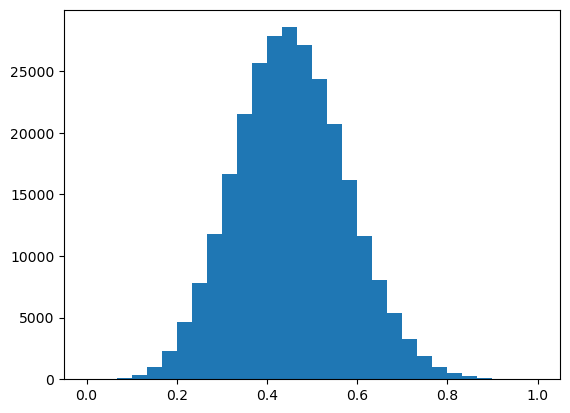

In [25]:
# 좌우반전 y_val_pred 분포
plt.hist(y_val_pred, bins=30)

In [26]:
thresholds, sharpe_ratios = [], []

# meta_val에 'irr', 'treasury' 컬럼이 반드시 포함되어 있어야 함!
for t in np.linspace(0.01, 0.99, 100):
    # 회귀 예측값을 threshold 이상이면 1(=> 대출 안 해줌), 아니면 0(=> 대출해줌)으로 간주
    val_binary = (y_val_pred > t).astype(int)
    val_return = []
    for pred, actual, irr, treasury in zip(val_binary, y_val, meta_val['irr'], meta_val['treasury']):
        if pred == 0:
            val_return.append(irr)
        else:
            val_return.append(treasury - irr)
    val_return = np.array(val_return)
    risk_free = np.array(meta_val['treasury'])
    excess_ret = val_return - risk_free
    if excess_ret.std() > 0:
        sharpe = excess_ret.mean() / excess_ret.std()
    else:
        sharpe = np.nan
    thresholds.append(t)
    sharpe_ratios.append(sharpe)

thresholds = np.array(thresholds)
sharpe_ratios = np.array(sharpe_ratios)

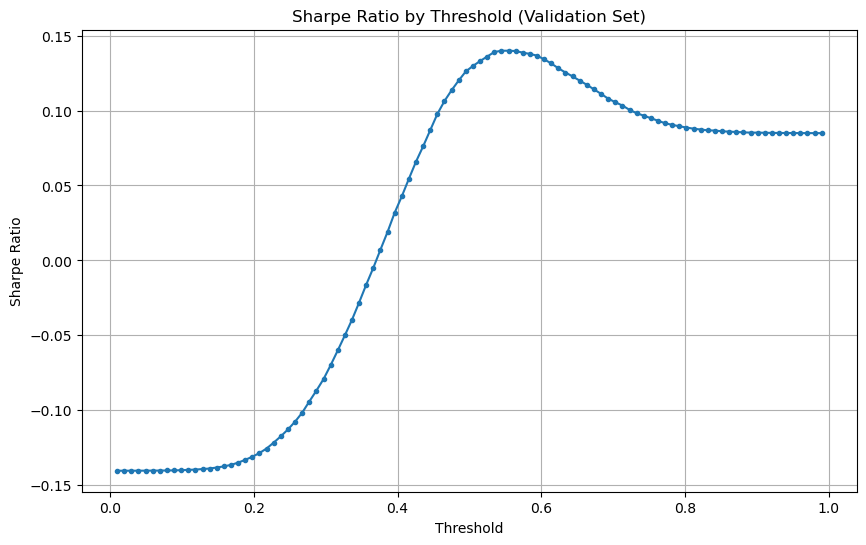

 Optimal Threshold: 0.545
 Max Sharpe Ratio: 0.1399


In [27]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, sharpe_ratios, marker='o', markersize=3)
plt.xlabel("Threshold")
plt.ylabel("Sharpe Ratio")
plt.title("Sharpe Ratio by Threshold (Validation Set)")
plt.grid(True)
plt.show()

optimal_idx = np.nanargmax(sharpe_ratios)
optimal_threshold = thresholds[optimal_idx]
print(f" Optimal Threshold: {optimal_threshold:.3f}")
print(f" Max Sharpe Ratio: {sharpe_ratios[optimal_idx]:.4f}")


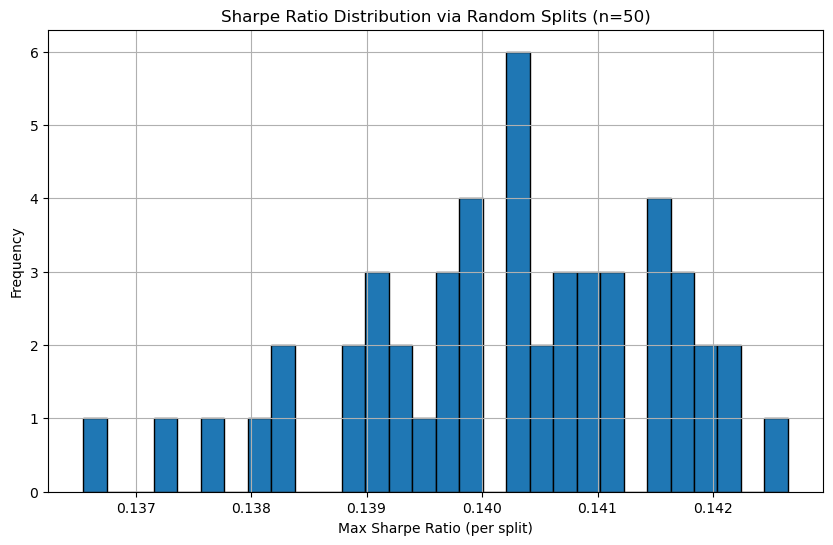

평균 Sharpe Ratio: 0.1402
최대 Sharpe Ratio: 0.1426
최소 Sharpe Ratio: 0.1365
중앙값 Sharpe Ratio: 0.1404
표준편차 Sharpe Ratio: 0.0013


In [28]:
from joblib import Parallel, delayed

N_BOOTSTRAP = 50
thresholds = np.linspace(0.01, 0.99, 100)
    
def calc_max_sharpe(seed):
    X_tr, X_val, y_tr, y_val, meta_tr, meta_val = train_test_split(
        X, y, meta, test_size=0.25, random_state=seed
    )
    X_tr = X_tr.copy()
    X_val = X_val.copy()
    meta_tr = meta_tr.reset_index(drop=True)
    meta_val = meta_val.reset_index(drop=True)
    y_val = y_val.reset_index(drop=True)

    lpm = LinearRegression()
    lpm.fit(X_tr, y_tr)
    y_val_pred = lpm.predict(X_val)
    # 2. min-max scaling
    y_val_pred_min_max = (y_val_pred - y_val_pred.min()) / (y_val_pred.max() - y_val_pred.min())
    # 3. 좌우대칭
    y_val_pred = 1 - y_val_pred_min_max

    thresholds, sharpe_ratios = [], []
    for t in np.linspace(0.01, 0.99, 100):
        val_binary = (y_val_pred > t).astype(int)
        val_return = []
        for pred, actual, irr, treasury in zip(val_binary, y_val, meta_val['irr'], meta_val['treasury']):
            if pred == 0:  # 대출
                val_return.append(irr)
            else:  # 대출 X
                val_return.append(treasury - irr)
        val_return = np.array(val_return)
        risk_free = np.array(meta_val['treasury'])
        excess_ret = val_return - risk_free
        if excess_ret.std() > 0:
            sharpe = excess_ret.mean() / excess_ret.std()
        else:
            sharpe = np.nan
        thresholds.append(t)
        sharpe_ratios.append(sharpe)

    sharpe_ratios = np.array(sharpe_ratios)
    max_sharpe = np.nanmax(sharpe_ratios)
    return max_sharpe

# 병렬 실행 (n_jobs=6 또는 -1 등 적절히 설정)
sharpe_dist = Parallel(n_jobs=7)(
    delayed(calc_max_sharpe)(seed) for seed in range(N_BOOTSTRAP)
)

plt.figure(figsize=(10,6))
plt.hist(sharpe_dist, bins=30, edgecolor='k', alpha=1)
plt.xlabel("Max Sharpe Ratio (per split)")
plt.ylabel("Frequency")
plt.title("Sharpe Ratio Distribution via Random Splits (n=50)")
plt.grid(True)
plt.show()

print(f"평균 Sharpe Ratio: {np.nanmean(sharpe_dist):.4f}")
print(f"최대 Sharpe Ratio: {np.nanmax(sharpe_dist):.4f}")
print(f"최소 Sharpe Ratio: {np.nanmin(sharpe_dist):.4f}")
print(f"중앙값 Sharpe Ratio: {np.nanmedian(sharpe_dist):.4f}")
print(f"표준편차 Sharpe Ratio: {np.nanstd(sharpe_dist):.4f}")
